In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle # para leer los archivos comprimidos (.p)
#%pip install matplotlib
#%pip install mpl-interactions
#%pip install ipympl
from IPython.core.display import display, HTML
#remove paddingss
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))
#parameters#####################
nsensores =3 # 1 a 4
SampleFreq=1400
nombreArchivo = './mediciones/07112023_3s____ok.p' #26102023.p' #'./datos/3sens_130423_2.p' #  './datos/oclusion_bien.p

#############################

with open(nombreArchivo, 'rb') as f:
    data = pickle.load(f)
    print("Datos extraidos de %s" %nombreArchivo)
    f.close()
    
s0_raw = data['sensor0']
if nsensores >= 2 :    s1_raw = data['sensor1']
if nsensores >= 3 :    s2_raw = data['sensor2']
if nsensores >= 4 :    s3_raw = data['sensor3']

n_samples = len(s0_raw) #1.5*60*2000 #min*60*fsamp

Datos extraidos de ./mediciones/07112023_3s____ok.p


<IPython.core.display.Javascript object>


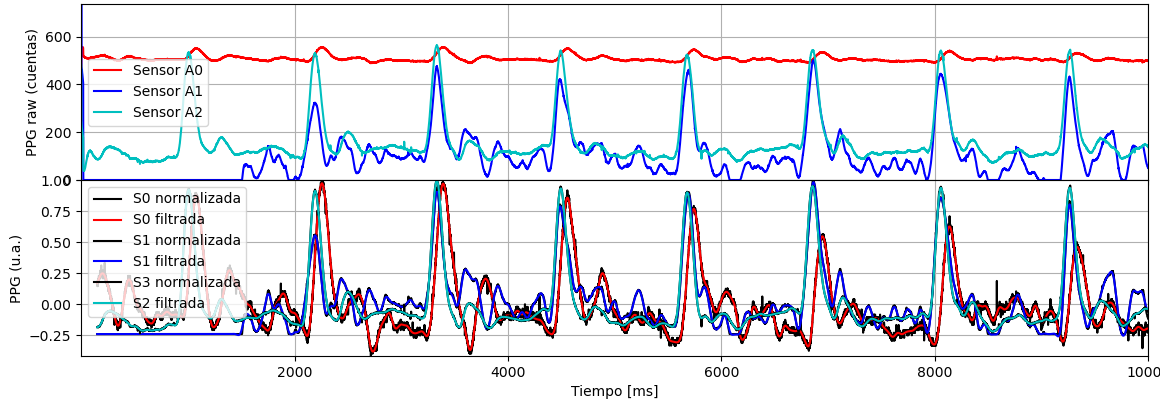

<IPython.core.display.Javascript object>


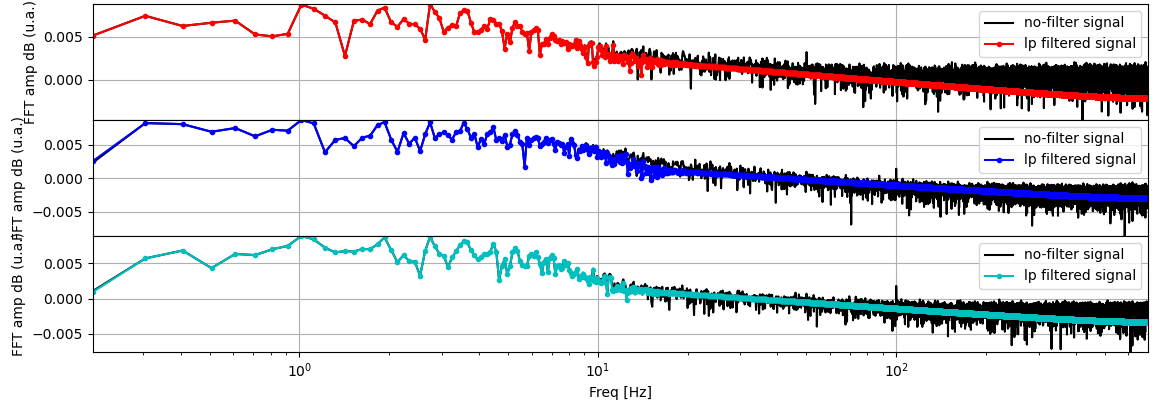

In [2]:
#preprocesamiento: normalizo y filtro señales

#enables zoom on figs:
%matplotlib notebook 

#-parameters-------------------------------------------------------------------
t_sec_discarded = 0.150
lp_cutoff_hz = 12      # desired cutoff frequency of the filter, Hz ,
lp_order = 3


# grafico señales sin procesar-----------------------------------------------------
fig = plt.figure(figsize = (11.6, 4)); ax0 = plt.subplot(211); ax0.margins(0, 0) #fig.suptitle('test title', fontsize=20)
SampleFreqKHz = SampleFreq/1000
#time_raw = np.arange(0, n_samples/SampleFreqKHz, 1/SampleFreqKHz) #; time = time[:n_samples]  #start stop step
time_raw = np.linspace(1/SampleFreqKHz, n_samples/SampleFreqKHz, n_samples) #; time = time[:n_samples]  #start stop step
#numpy.linspace start stop num
plt.plot(time_raw, s0_raw, 'r', label="Sensor A0")
if nsensores >= 2 :    plt.plot(time_raw, s1_raw, 'b', label="Sensor A1")
if nsensores >= 3 :    plt.plot(time_raw, s2_raw, 'c', label="Sensor A2")
if nsensores >= 4 :    plt.plot(time_raw, s3_raw, 'g', label="Sensor A3")
plt.xlabel("Tiempo [ms]"), plt.ylabel("PPG raw (cuentas)")#, plt.title("Señales ")
plt.legend(), plt.grid(), plt.setp(ax0.get_xticklabels(), visible=False), plt.show()

# normalizo y filtro #####################################################################

#descarto primeras muestras--
n_discarded = round(t_sec_discarded*SampleFreq) #
s0_trunc = s0_raw[n_discarded:] 
time = time_raw[n_discarded:] 
if nsensores >= 2 :    s1_trunc = s1_raw[n_discarded:] 
if nsensores >= 3 :    s2_trunc = s2_raw[n_discarded:] 
if nsensores >= 4 :    s3_trunc = s3_raw[n_discarded:] 

#filtro PB---------------------------------------------    
from scipy.signal import butter,filtfilt
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = lp_cutoff_hz / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)# Get the filter coefficients 
    y = filtfilt(b, a, data)
    return y

# normalizo  datos.--------------------------------------------
# resto valor medio y divido por el max
ax1 = plt.subplot(212, sharex = ax0); ax1.margins(0, 0)
s0_mean = s0_trunc - round(np.mean(s0_trunc)); 
s0_norm = s0_mean/np.max(s0_mean);# s0_nf = s0
plt.plot(time, s0_norm, 'k', label="S0 normalizada")
s0 = butter_lowpass_filter(s0_norm, lp_cutoff_hz, SampleFreq, order=lp_order)
plt.plot(time, s0, 'r', label="S0 filtrada")
if nsensores >= 2 :
    s1_mean = s1_trunc - round(np.mean(s1_trunc));    
    s1_norm = s1_mean/np.max(s1_mean); #   s1_nf = s1;
    plt.plot(time, s1_norm, 'k', label="S1 normalizada")
    s1 = butter_lowpass_filter(s1_norm, lp_cutoff_hz, SampleFreq, order=lp_order)
    plt.plot(time, s1, 'b', label="S1 filtrada")
if nsensores >= 3 :
    s2_mean = s2_trunc - round(np.mean(s2_trunc));     
    s2_norm = s2_mean/np.max(s2_mean);  # s2_nf = s2;
    s2 = butter_lowpass_filter(s2_norm, lp_cutoff_hz, SampleFreq, order=lp_order)
    plt.plot(time, s2_norm, 'k', label="S3 normalizada")
    plt.plot(time, s2, 'c', label="S2 filtrada")
if nsensores >= 4 :
    s3_mean = s3_trunc - round(np.mean(s3_trunc));     
    s3_norm = s3_mean/np.max(s3_mean);  #   s3_nf = s3;
    s3 = butter_lowpass_filter(s3_norm, lp_cutoff_hz, SampleFreq, order=lp_order)
    plt.plot(time, s3_norm, 'k')#, label="S3 normalizada")
    plt.plot(time, s3, 'g', label="S3 filtrada")

plt.xlabel("Tiempo [ms]"), plt.ylabel("PPG (u.a.)")#, plt.title("Señales normalizadas")
plt.legend(), plt.grid(), plt.subplots_adjust(hspace=.0) # remove vertical gap between subplots
plt.subplots_adjust(left=0.07, right=.99, top=.99, bottom=.11), plt.show()


#fft##############################################################################################################
from scipy.fft import fft, fftfreq

N = len(s0)  #freq points
yf = fft(s0)
yf_nf=  fft(s0_norm) 
xf = np.linspace(SampleFreq/(N//2), SampleFreq//2, N//2, endpoint=False)

fig = plt.figure(figsize = (11.6, 4)); 
ax0 = plt.subplot(nsensores,1,1); ax0.margins(0, 0) #fig.suptitle('test title', fontsize=20)
#ax1 = plt.subplot(2,1,1) 
#ax0 = plt.figure(figsize = (11.6, 4));  #ax0.margins(0, 0) #fig.suptitle('test title', fontsize=20)
plt.subplots_adjust(left=0.08, right=.99, top=.99, bottom=.12)
plt.plot(xf, 2.0/N * 20 * np.log10(np.abs(yf_nf[0:N//2])),'k', label="no-filter signal")
plt.plot(xf, 2.0/N * 20 * np.log10(np.abs(yf[0:N//2])), 'r',marker=".", label="lp filtered signal")
plt.xscale('log'), plt.grid(), plt.xlabel("Freq [Hz]"), plt.ylabel("FFT amp dB (u.a.)"), plt.legend(), plt.show();

if nsensores >= 2 :  
    N = len(s1)  #freq points
    yf = fft(s1)
    yf_nf=  fft(s1_norm) 
    #ax1 = plt.figure(figsize = (11.6, 4), sharex = ax0); #ax1 = plt.subplot(211); ax0.margins(0, 0) #fig.suptitle('test title', fontsize=20)
    #ax1 = plt.subplot(212, sharex = ax0); ax1.margins(0, 0)
    #ax1 = plt.subplot(211) 
    #plt.show();
    ax1 = plt.subplot(nsensores,1,2, sharex = ax0); ax1.margins(0, 0);
    #fig = plt.figure(figsize = (11.6, 4));  ax0.margins(0, 0) #fig.suptitle('test title', fontsize=20)
    plt.subplots_adjust(left=0.08, right=.99, top=.99, bottom=.12)
    plt.plot(xf, 2.0/N * 20 * np.log10(np.abs(yf_nf[0:N//2])),'k', label="no-filter signal")
    plt.plot(xf, 2.0/N * 20 * np.log10(np.abs(yf[0:N//2])),'b', marker=".", label="lp filtered signal")
    plt.xscale('log'), plt.grid(), plt.xlabel("Freq [Hz]"), plt.ylabel("FFT amp dB (u.a.)"), plt.legend(), plt.show();

if nsensores >= 3 :  
    N = len(s2)  #freq points
    yf = fft(s2)
    yf_nf=  fft(s2_norm) 
    ax2 = plt.subplot(nsensores,1,3, sharex = ax0); ax2.margins(0, 0)
    #ax2 = plt.figure(figsize = (11.6, 4));  #ax0.margins(0, 0) #fig.suptitle('test title', fontsize=20)
    plt.subplots_adjust(left=0.08, right=.99, top=.99, bottom=.12)
    plt.plot(xf, 2.0/N * 20 * np.log10(np.abs(yf_nf[0:N//2])),'k', label="no-filter signal")
    plt.plot(xf, 2.0/N * 20 * np.log10(np.abs(yf[0:N//2])),'c', marker=".", label="lp filtered signal")
    plt.xscale('log'), plt.grid(), plt.xlabel("Freq [Hz]"), plt.ylabel("FFT amp dB (u.a.)"), plt.legend(), plt.show();
    
plt.subplots_adjust(hspace=.0) # remove vertical gap between subplots


<IPython.core.display.Javascript object>


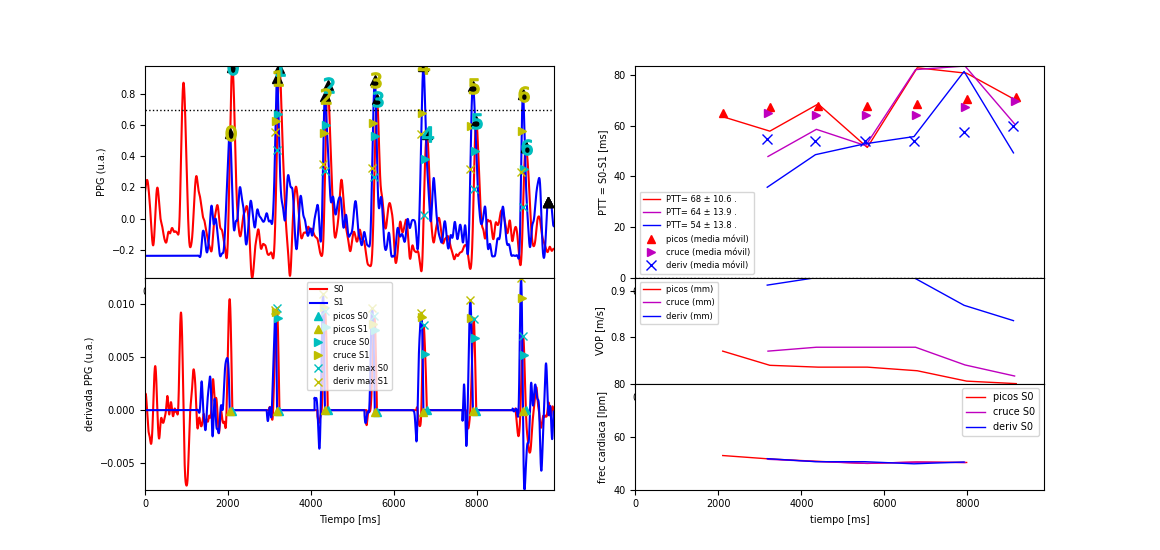

'plt.ylabel("PPG (u.a.)", fontsize=7), plt.xlabel("Tiempo [ms]", fontsize=7), plt.yticks(fontsize=7), plt.xticks(fontsize=7)\nplt.plot(time_ms[:len(s0)],       s0, \'r-\', label="S0") \nplt.plot(time_ms[:len(s1)],       s1, \'b-\', label="S1") \nplt.plot(time_ms[threshold_n_S0], s0[threshold_n_S0], \'c>\', label="cruce S0")\nplt.plot(time_ms[threshold_n_S1], s1[threshold_n_S1], \'y>\', label="cruce S1")\nplt.plot(time_ms[deriv_max_n_S0], s0[deriv_max_n_S0], "xc", label="deriv max S0")\nplt.plot(time_ms[deriv_max_n_S1], s1[deriv_max_n_S1], "xy", label="deriv max S1")*/\n#plt.plot(time_ms[threshold_n_S0], beats_power_array0[threshold_n_S0], \'ko\', label="power s0")'

In [3]:
#aplico filtro media movil, detecto picos, descarto picos sin pareja
#buscamos cruce por cero, derivada
#descarto latidos borde
#calculo deltaT de diferentes maneras
#calculo frec de diferentes maneras
#aplico filtro media movil a delta T
#calculo VOP
#grafico

#distance_sensors_mts=0.36 #0.36 .04y 0.08 # VOP VELOCIDAD DE ONDA DE PULSO--------------

distance_sensors_mts = 0.05 #.47 codo punta dedo// 0.26codo muñeca // .21 muñeca punta dedo dedo a dedod .055 #0.36 .04y 0.08 # VOP VELOCIDAD DE ONDA DE PULSO--------------

#s0_aux = s0
#s1_aux = s1
#s2_aux = s2
#
#s0 = s

#DETECTOR DE PICOS-------------------------------------------------------------------------------------------------------
from scipy.signal import find_peaks

bpm_max = 133
distance = round(60*SampleFreq/bpm_max) #min peak distance for a peak to be recognized.

# DETECTOR DE PICOS sobre la señal con filtrada
peaks_n_S0, _ = find_peaks(s0, distance=distance,height=0.1, width=50)
peaks_n_S1, _ = find_peaks(s1, distance=distance,height=0.1, width=50)# rojo

peaks_before_discarding_n_S0 = peaks_n_S0;
peaks_before_discarding_n_S1 = peaks_n_S1;

"""
beats_power_array0 = np.zeros(len(peaks_n_S0)-2);
for n_beat in range(1,len(peaks_n_S0)-1):
    latido = s0[peaks_n_S0[n_beat]:peaks_n_S0[n_beat+1]] 
    beats_power_array0[n_beat-1] = np.abs(latido)**2

np.power(x1, 3)
"""

#-discard peaks with no matching peak at both signals (when difference is greater than 100ms)-----------------------------------------
ptt_max_ms = 100       
i = -1
while  i< min(len(peaks_n_S1),len(peaks_n_S0))-1: #for j in range(0,min(len(peaks_n_S1),len(peaks_n_S0))):
    i = i+1
    #print("j: " + str(j) + " len(peaks_n_S1)=" + str(len(peaks_n_S1)) + ", len(peaks_n_S1)= " + str(len(peaks_n_S1)))
    #print("j: " + str(j)+ " len(peaks_n_S1)=" + str(len(peaks_n_S1))
    #print(i)
    #print(peaks_n_S0[i])
    if abs(peaks_n_S0[i] - peaks_n_S1[i])/SampleFreqKHz > ptt_max_ms: #peak1 with beat, peak0 no beat 
        if peaks_n_S0[i] < peaks_n_S1[i]:
            #print("discarded peak after beat nr "+str(i-1)+" at "+str(peaks_n_S0[i]/SampleFreq)+" for signal 0 (next peak at signal1 was at "+str(peaks_n_S1[i]/SampleFreq)+" >100ms after beat at signal0)")
            peaks_n_S0[i:-1] = peaks_n_S0[i+1:] #discard beat with no matching beat
            peaks_n_S0 = peaks_n_S0[:-1] #and discard last beat (repeated)
        else :
            #print("discarded peak after beat nr "+str(i-1)+" at "+str(peaks_n_S1[i]/SampleFreq)+" for signal 1 (next peak at signal0 was at "+str(peaks_n_S0[i]/SampleFreq)+" >100ms after beat at signal1)")
            peaks_n_S1[i:-1] = peaks_n_S1[i+1:] #discard beat with no matching beat
            peaks_n_S1 = peaks_n_S1[:-1] #and discard last beat (repeated), achico array
        i = i-1 #dont increase beat if theres no match
    #else: print("beat nr "+str(i)+" at "+str(peaks_n_S1[i]/SampleFreq)+" for signal 1 and "+str(peaks_n_S0[i]/SampleFreq)+" signal0, diff="+str(peaks_n_S0[i]-peaks_n_S1[i]) )
#eliminamos el ultimo latido que sobre
peaks_n_S0 = peaks_n_S0[0:min(len(peaks_n_S1),len(peaks_n_S0))]
peaks_n_S1 = peaks_n_S1[0:min(len(peaks_n_S1),len(peaks_n_S0))]
    
#-buscamos cruce -----------------------------------------------------------------------
threshold = .7 #from peak amplitude
threshold_n_S0 = []
len_beat_prev = peaks_n_S0[0];
for n_beat in range(0,len(peaks_n_S0)-1):
    latido = s0[peaks_n_S0[n_beat]:peaks_n_S0[n_beat+1]] 
    latido = latido - threshold*s0[peaks_n_S0[n_beat+1]]  #((np.max(latido)-np.min(latido))
    zero_crossings = np.where(np.diff(np.sign(latido)))[0]
    threshold_n_S0.append(int(len_beat_prev + zero_crossings[-1]))
    len_beat_prev = len_beat_prev + len(latido)
threshold_n_S0 =  np.array(threshold_n_S0)

threshold_n_S1 = []
len_beat_prev = peaks_n_S1[0];
for n_beat in range(0,len(peaks_n_S1)-1):
    latido = s1[peaks_n_S1[n_beat]:peaks_n_S1[n_beat+1]]   
    latido = latido - threshold*s1[peaks_n_S1[n_beat+1]]  #(np.max(latido)-np.min(latido))
    zero_crossings = np.where(np.diff(np.sign(latido)))[0]
    threshold_n_S1.append(int(len_beat_prev + zero_crossings[-1]))
    len_beat_prev = len_beat_prev + len(latido)
threshold_n_S1 =  np.array(threshold_n_S1)

#-calculamos derivada--------------------------------------------------------------
deriv_window_time_ms = 250 # ventana temporal sistolica (desde pico del latido) donde busco maxima derivada
n_deriv_samples = 1 # elegimos el Delta T de la derivada = Df(t)/DT

deriv_S0 =  s0[n_deriv_samples:] - s0[:-n_deriv_samples]
deriv_max_n_S0 = []# buscamos el max dentro de cada latido #####
len_beat_prev = peaks_n_S0[0]; #si ponemos cero no coincide el pico con el maximo en el grafico
for n_beat in range(0,len(peaks_n_S0)-1):
    latido_len = len(deriv_S0[peaks_n_S0[n_beat]:peaks_n_S0[n_beat+1]])
    #buscar maxima derivada desde el pico de ppg  hacia atras en el tiempo
    deriv_S0[peaks_n_S0[n_beat]+1:peaks_n_S0[n_beat+1]-round(deriv_window_time_ms/1000*SampleFreq)] = 0
    latido_deriv = deriv_S0[peaks_n_S0[n_beat]:peaks_n_S0[n_beat+1]] 
    deriv_max0 = np.argmax(latido_deriv)
    deriv_max_n_S0.append(int(len_beat_prev + deriv_max0))
    len_beat_prev = len_beat_prev + latido_len
deriv_max_n_S0 =  np.array(deriv_max_n_S0)

deriv_S1 =  s1[n_deriv_samples:] - s1[:-n_deriv_samples]
deriv_max_n_S1 = []
len_beat_prev = peaks_n_S1[0];
for n_beat in range(0,len(peaks_n_S1)-1):
    latido_len = len(deriv_S1[peaks_n_S1[n_beat]:peaks_n_S1[n_beat+1]])
    deriv_S1[peaks_n_S1[n_beat]+1:peaks_n_S1[n_beat+1]-round(deriv_window_time_ms/1000*SampleFreq)] = 0
    latido_deriv = deriv_S1[peaks_n_S1[n_beat]:peaks_n_S1[n_beat+1]] 
    deriv_max1 = np.argmax(latido_deriv)
    deriv_max_n_S1.append(int(len_beat_prev + deriv_max1))
    len_beat_prev = len_beat_prev + latido_len
deriv_max_n_S1 =  np.array(deriv_max_n_S1)




# frec cardiaca---------------------------------------------------------------------------------------------------------
heartrate_peaks_S1    = 60*SampleFreq/abs(peaks_n_S1[:-1] - peaks_n_S1[1:]) 
heartrate_peaks_S0    = 60*SampleFreq/abs(peaks_n_S0[:-1] - peaks_n_S0[1:])
heartrate_theshold_S0 = 60*SampleFreq/abs(threshold_n_S0[:-1] - threshold_n_S0[1:])  
heartrate_deriv_S0    = 60*SampleFreq/abs(deriv_max_n_S0[:-1] - deriv_max_n_S0[1:]) 

# PULSE TRANSIT TIME ----PTT---------------------------------------------------------------------------------------------
deltaT_peaks =     (peaks_n_S0 - peaks_n_S1)/SampleFreqKHz
deltaT_threshold = (threshold_n_S0 - threshold_n_S1)/SampleFreqKHz
deltaT_deriv =     (deriv_max_n_S0 - deriv_max_n_S1)/SampleFreqKHz

#discard deltaT higher than 100ms (found beat on one signal but not in the other)
#for n_beat in range(2,len(deltaT_threshold)-1):
#    if deltaT_threshold[n_beat] > 100:
#        deltaT_threshold[n_beat] = deltaT_threshold[n_beat-1]
 #porque no lo hacemos en el resto de los arrays???       
        
# FILTRO MEDIA MOVIL a deltaT ------
window_size = 8
arr = deltaT_peaks
moving_averages = []
for i in range(0,len(arr)):
    start = int(max(np.ceil(i-(window_size-1)/2),0))
    end = int(min(np.floor(i+window_size/2)+1,len(arr)))
    moving_averages.append(np.mean(arr[start:end]))
deltaT_peaks_ma=  np.array(moving_averages)

arr = deltaT_threshold
moving_averages = []
for i in range(0,len(arr)):
    start = int(max(np.ceil(i-(window_size-1)/2),0))
    end = int(min(np.floor(i+window_size/2)+1,len(arr)))
    moving_averages.append(np.mean(arr[start:end]))
deltaT_threshold_ma =  np.array(moving_averages)
 
arr = deltaT_deriv
moving_averages = []
for i in range(0,len(arr)):
    start = int(max(np.ceil(i-(window_size-1)/2),0))
    end = int(min(np.floor(i+window_size/2)+1,len(arr)))
    moving_averages.append(np.mean(arr[start:end]))
deltaT_deriv_ma =  np.array(moving_averages)


################################################################################################################
##plots #################################################################################################################################

fig = plt.figure(figsize = (11.6, 5.5))
time_ms = np.arange(0,n_samples/SampleFreqKHz,1/SampleFreqKHz)

#-señal temporal -------------------------------------------------
ax0 = plt.subplot(2,2,1); ax0.margins(0, 0) 
plt.ylabel("PPG (u.a.)", fontsize=7), plt.xlabel("Tiempo [ms]", fontsize=7), plt.yticks(fontsize=7), plt.xticks(fontsize=7)
plt.plot(time_ms[:len(s0)],       s0, 'r-', label="S0") 
plt.plot(time_ms[:len(s1)],       s1, 'b-', label="S1") 
plt.plot(time_ms[threshold_n_S0], s0[threshold_n_S0], 'c>', label="cruce S0")
plt.plot(time_ms[threshold_n_S1], s1[threshold_n_S1], 'y>', label="cruce S1")
plt.plot(time_ms[deriv_max_n_S0], s0[deriv_max_n_S0], "xc", label="deriv max S0")
plt.plot(time_ms[deriv_max_n_S1], s1[deriv_max_n_S1], "xy", label="deriv max S1")
#plt.plot(time_ms[threshold_n_S0], beats_power_array0[threshold_n_S0], 'ko', label="power s0")
for i in range(0,len(peaks_before_discarding_n_S0)):
    plt.plot(time_ms[peaks_before_discarding_n_S0[i]],     s0[peaks_before_discarding_n_S0[i]], markersize=7, color="k", marker='^', label="picos descartados")
for i in range(0,len(peaks_before_discarding_n_S1)):
    plt.plot(time_ms[peaks_before_discarding_n_S1[i]],     s1[peaks_before_discarding_n_S1[i]], markersize=7, color="k",marker='^', label="picos descartados")
for i in range(0,len(peaks_n_S0)):
    plt.plot(time_ms[peaks_n_S0[i]], s0[peaks_n_S0[i]], markersize=11, color="c", marker='$'+str(i)+'$', label="picos A")
for i in range(0,len(peaks_n_S1)):
    plt.plot(time_ms[peaks_n_S1[i]], s1[peaks_n_S1[i]], markersize=11, color="y",marker='$'+str(i)+'$', label="picos A")


plt.axhline(y=threshold,linewidth=1, color='k', linestyle=':')#'-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

#- deriv-------------------------------------------------
ax1 = plt.subplot(2,2,3, sharex = ax0); ax1.margins(0, 0); plt.subplots_adjust(hspace=.0) # remove vertical gap between subplots  
plt.ylabel("derivada PPG (u.a.)", fontsize=7), plt.xlabel("Tiempo [ms]", fontsize=7), plt.yticks(fontsize=7), plt.xticks(fontsize=7)
plt.plot(time_ms[:len(deriv_S0)], deriv_S0, 'r-', label="S0") 
plt.plot(time_ms[:len(deriv_S0)], deriv_S1, 'b-', label="S1")
plt.plot(time_ms[peaks_n_S0],     deriv_S0[peaks_n_S0], "^c", label="picos S0")
plt.plot(time_ms[peaks_n_S1],     deriv_S1[peaks_n_S1], "^y", label="picos S1")
plt.plot(time_ms[threshold_n_S0], deriv_S0[threshold_n_S0], ">c", label="cruce S0")
plt.plot(time_ms[threshold_n_S1], deriv_S1[threshold_n_S1], ">y", label="cruce S1")
plt.plot(time_ms[deriv_max_n_S0], deriv_S0[deriv_max_n_S0], 'cx', label="deriv max S0")
plt.plot(time_ms[deriv_max_n_S1], deriv_S1[deriv_max_n_S1], 'yx', label="deriv max S1")
plt.legend(prop={'size': 6})

#--PTT------------------------------------------
ax2 = plt.subplot(2,2,2, sharex = ax0); ax2.margins(0, 0);
plt.ylabel("PTT = S0-S1 [ms]", fontsize=7), plt.xlabel("Tiempo [ms]", fontsize=7), plt.yticks(fontsize=7), plt.xticks(fontsize=7)
myorder = "PTT= {:.0f} ± {:.1f} ."
plt.plot(time_ms[peaks_n_S0],     deltaT_peaks,        'r-', label= myorder.format(np.mean(deltaT_peaks), np.std(deltaT_peaks)),         markersize=2, lw=1.0)
plt.plot(time_ms[threshold_n_S0], deltaT_threshold,    'm-', label= myorder.format(np.mean(deltaT_threshold), np.std(deltaT_threshold)), markersize=2, lw=1.0)
plt.plot(time_ms[deriv_max_n_S0], deltaT_deriv,        'b-', label= myorder.format(np.mean(deltaT_deriv), np.std(deltaT_deriv)),         markersize=2, lw=1.0)
plt.plot(time_ms[peaks_n_S0],     deltaT_peaks_ma,     'r^', label="picos (media móvil)")
plt.plot(time_ms[threshold_n_S0], deltaT_threshold_ma, 'm>', label="cruce (media móvil)")
plt.plot(time_ms[deriv_max_n_S0], deltaT_deriv_ma,     'bx', label="deriv (media móvil)", markersize=7)
plt.legend(prop={'size': 6})#, plt.ylim(-30,30)
plt.axhline(y=0,linewidth=1, color='k', linestyle=':')#'-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

#-  VOP---------------------------------------------------------------
ax3 = plt.subplot(4,2,6, sharex = ax0); ax3.margins(0, 0);
plt.ylabel("VOP [m/s]", fontsize=7), plt.xlabel("tiempo [ms]", fontsize=7), plt.yticks(fontsize=7), plt.xticks(fontsize=7)
plt.plot(time_ms[peaks_n_S0],      distance_sensors_mts*1000/deltaT_peaks_ma, 'r-', label='picos (mm)', lw=1.0)    #  ptt con media movil
plt.plot(time_ms[threshold_n_S0],  distance_sensors_mts*1000/deltaT_threshold_ma, 'm-', label='cruce (mm)', lw=1.0)   #  ptt detectada con cruce por cero
plt.plot(time_ms[deriv_max_n_S0],  distance_sensors_mts*1000/deltaT_deriv_ma, 'b-', label='deriv (mm)', lw=1.0)      #  ptt detectada con reconstrucción derivada
plt.legend(prop={'size': 6})#, plt.ylim(-30,30)

#- frec cardiaca ---------------------------------------------------------------------
ax4 = plt.subplot(4,2,8, sharex = ax0); ax4.margins(0, 0);
plt.ylabel("frec cardiaca [lpm]", fontsize=7), plt.xlabel("tiempo [ms]", fontsize=7), plt.yticks(fontsize=7), plt.xticks(fontsize=7)
plt.plot(time_ms[peaks_n_S0[:-1]],      heartrate_peaks_S0,    'r-', label='picos S0', lw=1.0)   #  ptt detectada con cruce por cero
plt.plot(time_ms[threshold_n_S0[:-1]],  heartrate_theshold_S0, 'm-', label='cruce S0', lw=1.0)   #  ptt detectada con cruce por cero
plt.plot(time_ms[deriv_max_n_S0[:-1]],  heartrate_deriv_S0,    'b-', label='deriv S0', lw=1.0)   #  ptt detectada con cruce por cero
plt.ylim(40,80), plt.legend(prop={'size': 7}), plt.show



#-------------------------
##################################################################################

#-señal temporal -------------------------------------------------
#ax0 = plt.subplot(2,2,1); ax0.margins(0, 0) 
"""plt.ylabel("PPG (u.a.)", fontsize=7), plt.xlabel("Tiempo [ms]", fontsize=7), plt.yticks(fontsize=7), plt.xticks(fontsize=7)
plt.plot(time_ms[:len(s0)],       s0, 'r-', label="S0") 
plt.plot(time_ms[:len(s1)],       s1, 'b-', label="S1") 
plt.plot(time_ms[threshold_n_S0], s0[threshold_n_S0], 'c>', label="cruce S0")
plt.plot(time_ms[threshold_n_S1], s1[threshold_n_S1], 'y>', label="cruce S1")
plt.plot(time_ms[deriv_max_n_S0], s0[deriv_max_n_S0], "xc", label="deriv max S0")
plt.plot(time_ms[deriv_max_n_S1], s1[deriv_max_n_S1], "xy", label="deriv max S1")*/
#plt.plot(time_ms[threshold_n_S0], beats_power_array0[threshold_n_S0], 'ko', label="power s0")"""



<IPython.core.display.Javascript object>


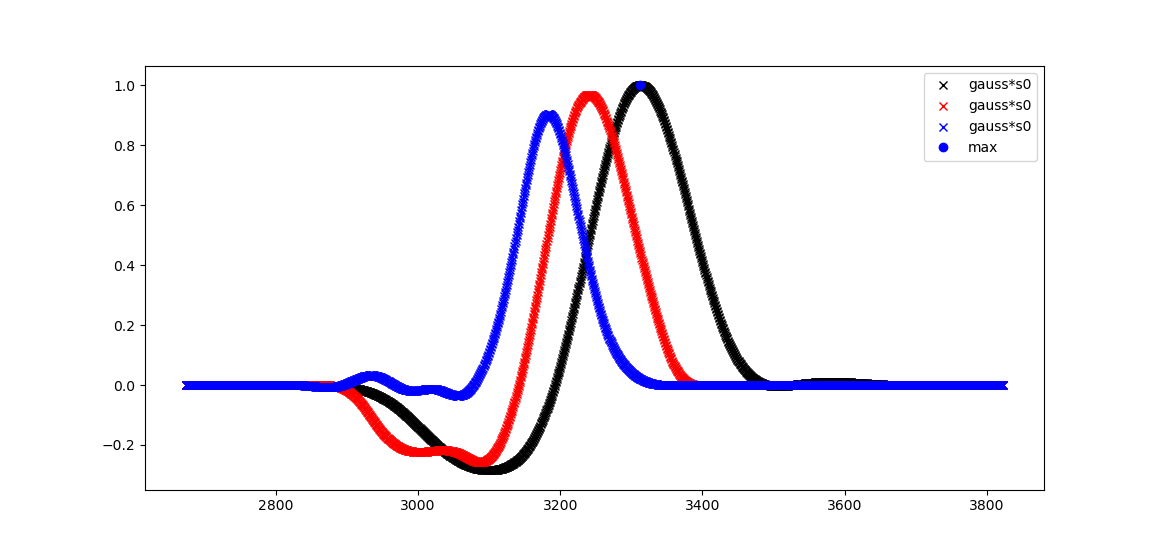

In [7]:
#correlacion
from scipy import signal

fig = plt.figure(figsize = (11.6, 5.5))

def gaussian(x, mu, sig):  #x:time, mu: center, sig:width p:power (gaussiana generalizada)
    return 1.0 * np.exp(-np.power((x - mu) / sig, 2.0*4) / 2)
    #return 1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
deriv_window_time_ms = 250 # ventana temporal sistolica (desde pico del latido) donde busco maxima derivada
gauss_width_ms = 200
gauss_offset_before_peak_ms = 100;
#corr_S0S1 =  s0[n_deriv_samples:] - s0[:-n_deriv_samples]
corr_max_ms_all = []# buscamos el max dentro de cada latido #####
corr_max_all = []# buscamos el max dentro de cada latido #####
t_corr_all = []
corr_s0s1_all = []
s0g_corr_all = []
s1g_corr_all = []
lags_ms_all = []

len_beat_prev = peaks_n_S0[0]; #si ponemos cero no coincide el pico con el maximo en el grafico
for n_beat in range(0,1):#len(peaks_n_S0)-2):
    #buscar maxima derivada desde el pico de ppg  hacia atras en el tiempo
    #s0[peaks_n_S0[n_beat]+1:peaks_n_S0[n_beat+1]-round(deriv_window_time_ms/1000*SampleFreq)] = 0
    #n0 = peaks_n_S0[n_beat]+1
    #n1 = peaks_n_S0[n_beat+2]
    n0 = int(np.mean([peaks_n_S0[n_beat]+1, peaks_n_S0[n_beat+1]]))
    n1 = int(np.mean([peaks_n_S0[n_beat+1]+1, peaks_n_S0[n_beat+2]]))
    t_corr = time_ms[n0:n1]
    s0_corr = s0[n0:n1]
    gs0 = gaussian(t_corr, time_ms[peaks_n_S0[n_beat+1]]-gauss_offset_before_peak_ms, gauss_width_ms) #centered respect to signal0 peak
    s0g_corr = s0_corr*gs0 #windowed with gaussian: ones at peak, fades to zeros outside peak
    s1_corr = s1[n0:n1]
    gs1 = gaussian(t_corr, time_ms[peaks_n_S1[n_beat+1]]-gauss_offset_before_peak_ms, gauss_width_ms) #centered respect to signal1 peak
    s1g_corr = s1_corr*gs1

    corr_S0S1 = np.correlate(s0g_corr, s1g_corr, mode='full') #‘full’: output shape of N+M-1
    corr_S0S1 = corr_S0S1/max(corr_S0S1)
    lags_ms = signal.correlation_lags(len(s0_corr), len(s0_corr), mode="full")/SampleFreqKHz
    
    lags_ms = -lags_ms #lags_ms = np.flip(lags_ms)
    PTT_corr_ms = lags_ms[np.argmax(corr_S0S1)]

    n4 = np.argmax(lags_ms + time_ms[peaks_n_S0[n_beat+1]+1] < t_corr[0]) #find when lag is inside beat window 
    n3 = np.argmax(lags_ms + time_ms[peaks_n_S0[n_beat+1]+1] <= t_corr[-1])
    lags_ms = lags_ms[n3:n4]
    corr_S0S1 = corr_S0S1[n3:n4]
    

    lags_ms_all = lags_ms_all + list(lags_ms+n0/SampleFreqKHz)
    t_corr_all = t_corr_all + list(t_corr)
    corr_s0s1_all = corr_s0s1_all + list(corr_S0S1)
    s0g_corr_all = s0g_corr_all + list(s0g_corr)
    s1g_corr_all = s1g_corr_all + list(s1g_corr)
    corr_max_ms_all.append((np.argmax(corr_S0S1)+n0)/SampleFreqKHz)
    corr_max_all.append(max(corr_S0S1))
    #len_beat_prev = len_beat_prev + latido_len
t_corr_all =  np.array(t_corr_all)
corr_s0s1_all =  np.array(corr_s0s1_all)
corr_max_ms_all =  np.array(corr_max_ms_all)
corr_max_all =  np.array(corr_max_all)
s0g_corr_all =  np.array(s0g_corr_all)
s1g_corr_all =  np.array(s1g_corr_all)
lags_ms_all = np.array(lags_ms_all)
#for i in range(1,2):
#plt.plot(t_corr, s0_corr, markersize=5, color="r", label="picos S0")
#plt.plot(t_corr, s1_corr, markersize=5, color="b", label="picos S1")
#plt.plot(t_corr, gs0, color="c", label="gauss")
#plt.plot(t_corr, gs1, color="c", label="gauss")
plt.plot(t_corr_all, corr_s0s1_all, ":k", label="gauss*s0")
plt.plot(t_corr_all, s0g_corr_all, ":r", label="gauss*s0")
plt.plot(t_corr_all, s1g_corr_all, ":b", label="gauss*s0")
plt.plot(corr_max_ms_all, corr_max_all, "ob", label="max")
#plt.plot(t_corr_all, s1g_corr_all, color="b", label="gauss*s1")

#plt.plot(time_ms[:len(s0)],       s0, 'r-', label="S0") 
#plt.plot(time_ms[:len(s1)],       s1, 'b-', label="S1") 

#plt.plot(t_corr, s0g_corr, "or", label="gauss*s0")
#plt.plot(t_corr, s1g_corr, color="b", label="gauss*s1")
#plt.plot(lags_ms+time_ms[peaks_n_S0[n_beat+1]+1], corr_S0S1,'xc', label="corr")
#plt.plot(-lags_ms+time_ms[peaks_n_S0[n_beat+1]+1], corr_S0S1/max(corr_S0S1),'--k', label="corr")
#plt.plot(PTT_corr_ms+time_ms[peaks_n_S0[n_beat+1]+1], corr_S0S1[np.argmax(corr_S0S1)],'xk', label="corr")
plt.legend()
